In [1]:
# Auto-reload modules when they change
%load_ext autoreload
%autoreload 2

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

# Local imports
from qml import HybridQuantumMultiClassCNN

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load Dataset

In [8]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# MNIST images are 28x28
IMAGE_SIZE = 28  
# Set to an int (e.g., 1000) for quick validation, None for full dataset
LIMIT_SAMPLES = 1000  

# Transform for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load MNIST dataset
train_dataset_full = datasets.MNIST(root='../data/MNIST', train=True, download=True, transform=transform)
test_dataset_full = datasets.MNIST(root='../data/MNIST', train=False, download=True, transform=transform)

# Limit dataset size if specified
if LIMIT_SAMPLES is not None:
    train_dataset = Subset(train_dataset_full, range(min(LIMIT_SAMPLES, len(train_dataset_full))))
    test_dataset = Subset(test_dataset_full, range(min(LIMIT_SAMPLES // 5, len(test_dataset_full))))
else:
    train_dataset = train_dataset_full
    test_dataset = test_dataset_full

print(f"Training images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")
print(f"Image shape: {train_dataset_full[0][0].shape}")
print(f"Number of classes: {len(train_dataset_full.classes)}")

Training images: 1000
Test images: 200
Image shape: torch.Size([1, 28, 28])
Number of classes: 10


In [9]:
# DataLoader configuration
BATCH_SIZE = 32

# Create data loaders from the pre-split datasets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {BATCH_SIZE}")

Train batches: 32
Test batches: 7
Batch size: 32


## Create Quantum CNN Model

In [18]:
# Model configuration
from qml.ansatz.dense import DenseQCNNAnsatz


model = HybridQuantumMultiClassCNN(
    num_classes=10,  # MNIST has 10 classes (digits 0-9)
    kernel_size=8,
    stride=8,
    pool_size=8,
    encoding='dense',
    ansatz=DenseQCNNAnsatz(),
    measurement='z'
)

model = model.to(device)
print(f"Model output classes: {model.num_classes}")

Using lightning.qubit device with 'dense' encoding, DenseQCNNAnsatz, measurement=PauliZ
Model output classes: 10


## Setup Training

In [19]:
from notebooks.multiclass_trainer import MultiClassTrainer

# Training configuration
LEARNING_RATE = 0.01
EPOCHS = 10

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Create trainer
trainer = MultiClassTrainer(
    criterion=criterion,
    device=device,
    max_grad_norm=1.0,
    log_interval=10
)

## Train Model
With test evaluation after each epoch

In [20]:
results = trainer.train(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    epochs=EPOCHS,
    test_loader=test_loader
)

Evaluating: 100%|██████████| 7/7 [00:15<00:00,  2.17s/it]


Epoch 1: Train Loss=2.1621, Train Acc=0.2190 | Test Loss=2.1486, Test Acc=0.2250


Evaluating: 100%|██████████| 7/7 [00:15<00:00,  2.19s/it]


Epoch 2: Train Loss=1.9143, Train Acc=0.3240 | Test Loss=2.0448, Test Acc=0.2600


Evaluating: 100%|██████████| 7/7 [00:16<00:00,  2.37s/it]


Epoch 3: Train Loss=1.7890, Train Acc=0.3730 | Test Loss=1.9463, Test Acc=0.3100


Evaluating: 100%|██████████| 7/7 [00:19<00:00,  2.81s/it]


Epoch 4: Train Loss=1.7016, Train Acc=0.3810 | Test Loss=1.9063, Test Acc=0.3250


Evaluating: 100%|██████████| 7/7 [00:17<00:00,  2.43s/it]


Epoch 5: Train Loss=1.6470, Train Acc=0.4050 | Test Loss=1.8897, Test Acc=0.3500


Evaluating: 100%|██████████| 7/7 [00:18<00:00,  2.62s/it]


Epoch 6: Train Loss=1.6152, Train Acc=0.4180 | Test Loss=1.8777, Test Acc=0.3550


Evaluating: 100%|██████████| 7/7 [00:17<00:00,  2.48s/it]


Epoch 7: Train Loss=1.5639, Train Acc=0.4410 | Test Loss=1.8354, Test Acc=0.3700


Evaluating: 100%|██████████| 7/7 [00:16<00:00,  2.41s/it]


Epoch 8: Train Loss=1.5296, Train Acc=0.4500 | Test Loss=1.8375, Test Acc=0.4000


Evaluating: 100%|██████████| 7/7 [00:15<00:00,  2.16s/it]


Epoch 9: Train Loss=1.5148, Train Acc=0.4510 | Test Loss=1.8705, Test Acc=0.4000


Evaluating: 100%|██████████| 7/7 [00:15<00:00,  2.18s/it]

Epoch 10: Train Loss=1.4816, Train Acc=0.4600 | Test Loss=1.7994, Test Acc=0.3850


## Train results

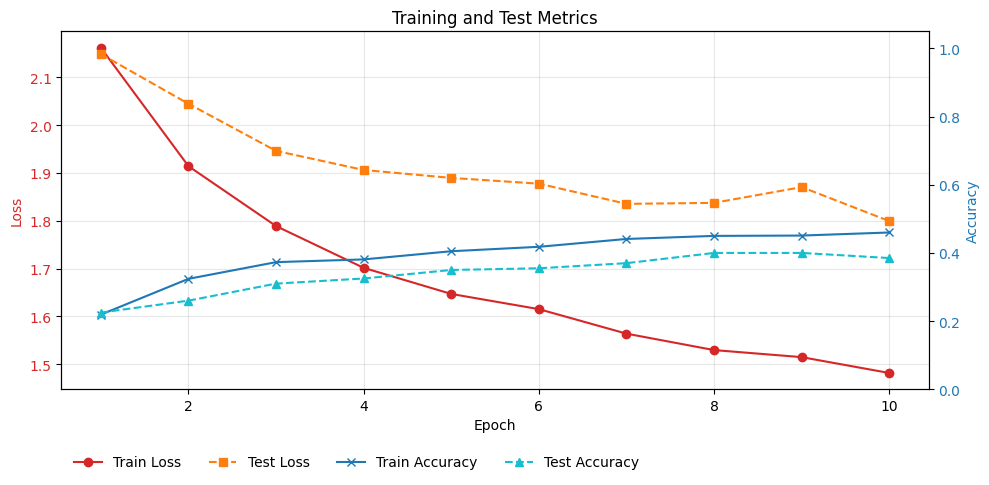

In [21]:
from notebooks.utils import plot_loss_and_accuracy

plot_loss_and_accuracy(
    losses=results['train_loss'],
    accuracies=results['train_acc'],
    test_losses=results['test_loss'],
    test_accuracies=results['test_acc']
)

Evaluating: 100%|██████████| 7/7 [00:15<00:00,  2.22s/it]



Final Test Results:
Test Loss: 1.7994
Test Accuracy: 0.3850


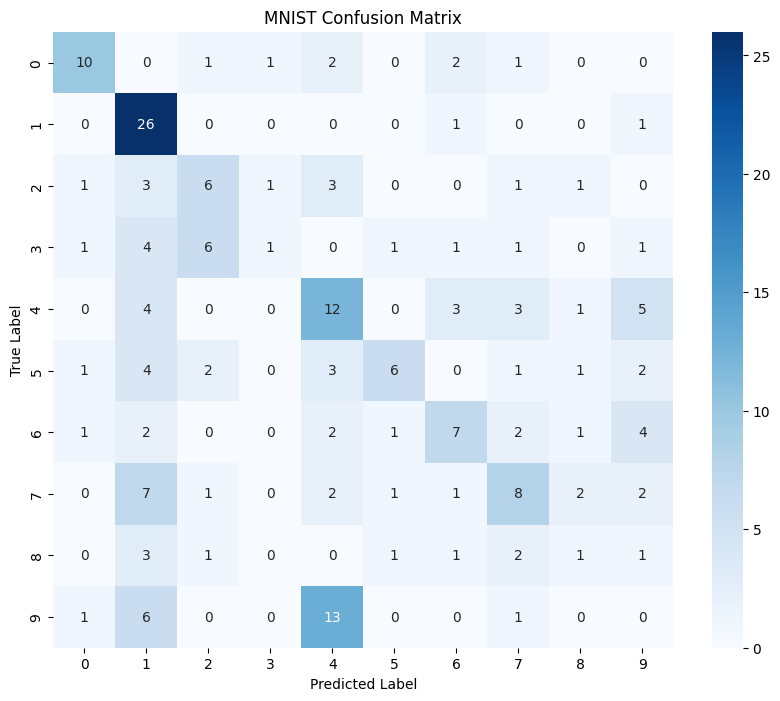


Per-Class Metrics:
Class    Precision    Recall       F1-Score    
------------------------------------------------
0        0.6667       0.5882       0.6250      
1        0.4407       0.9286       0.5977      
2        0.3529       0.3750       0.3636      
3        0.3333       0.0625       0.1053      
4        0.3243       0.4286       0.3692      
5        0.6000       0.3000       0.4000      
6        0.4375       0.3500       0.3889      
7        0.4000       0.3333       0.3636      
8        0.1429       0.1000       0.1176      
9        0.0000       0.0000       0.0000      

Overall Accuracy: 0.3850


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluate on test set
(test_loss, test_acc), confusion_matrix = trainer.evaluate(model, test_loader)

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Plot confusion matrix for 10 classes
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(i) for i in range(10)], 
            yticklabels=[str(i) for i in range(10)])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('MNIST Confusion Matrix')
plt.show()

# Calculate per-class metrics
print(f"\nPer-Class Metrics:")
print(f"{'Class':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 48)

for i in range(10):
    tp = confusion_matrix[i, i]
    fp = confusion_matrix[:, i].sum() - tp
    fn = confusion_matrix[i, :].sum() - tp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"{i:<8} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f}")

# Overall metrics
total_correct = np.trace(confusion_matrix)
total_samples = confusion_matrix.sum()
print(f"\nOverall Accuracy: {total_correct / total_samples:.4f}")